In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import keras
from keras.models import Sequential
from keras.layers import Flatten, LSTM, Dense, TimeDistributed, BatchNormalization
from keras.layers import Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.losses import mean_squared_error
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
import cv2
import glob
import re

folder_path = '/kaggle/input/clouds-modeling-segmented-images'
images = []

# Get a list of image file paths in the folder
image_paths = glob.glob(f'{folder_path}/*.jpg')

# Extract and sort the numerical part of the image paths
sorted_image_paths = sorted(image_paths, key=lambda x: int(re.search(r'\d+', x).group()))

# Iterate through the sorted image paths
for image_path in sorted_image_paths:
    # Read the image
    #print(image_path)
    # img = cv2.imread(image_path)
    img = cv2.imread(image_path, 0)
    
    #     # Resize the image to 150x150 pixels
    img_resized = cv2.resize(img, (280, 280), interpolation=cv2.INTER_AREA)
    
    images.append(img_resized)

# Now 'images' contains all the images in sequential order
images=np.array(images)/255.0

# Build the Model
model = Sequential()
model.add(BatchNormalization(input_shape=(4,280,280,1)))
model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
model.add(TimeDistributed(Dropout(0.4)))
model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
model.add(TimeDistributed(Dropout(0.4)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(units=1024, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(units=1024, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))
model.add(Dense(78400, activation='softplus')) # output layer based on 252*252 pixels 
model.compile(optimizer=Adam(), loss='mean_squared_error')
model.summary()

x=[]
y=[]
y1=[]
for i in range(1,240):
  x.append(np.asarray(images[i:i+4]).reshape(4,280,280,1))
for j in range(1,240):
  y1.append( np.asarray(images[j+4]).reshape(78400))
  y.append( np.asarray(images[j+4]).reshape(280,280,1))

x = np.array(x)
y = np.array(y)
y1 = np.array(y1)

print(x.shape , y.shape , y1.shape)

import time
start_time = time.time()
model.fit(x, y1,batch_size=16, epochs=50)
print("Time taken to train: " + str(time.time() - start_time))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Ba  (None, 4, 280, 280, 1)    4         
 tchNormalization)                                               
                                                                 
 time_distributed_39 (TimeD  (None, 4, 278, 278, 32)   320       
 istributed)                                                     
                                                                 
 time_distributed_40 (TimeD  (None, 4, 278, 278, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_41 (TimeD  (None, 4, 276, 276, 32)   9248      
 istributed)                                                     
                                                                 
 time_distributed_42 (TimeD  (None, 4, 276, 276, 32)  

In [8]:
model.save("cloud_motion_model.h5")

In [1]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import keras
from keras.models import Sequential
from keras.layers import Flatten, LSTM, Dense, TimeDistributed, BatchNormalization
from keras.layers import Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.losses import mean_squared_error
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
import cv2
import glob
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
from sklearn.metrics import matthews_corrcoef
from skimage.metrics import structural_similarity as compare_ssim


folder_path = r"C:/New Project/Segmented_Images_Renamed"
images = []

# Get a list of image file paths in the folder
image_paths = glob.glob(f'{folder_path}/*.jpg')

# Extract and sort the numerical part of the image paths
sorted_image_paths = sorted(image_paths, key=lambda x: int(re.search(r'\d+', x).group()))

# Iterate through the sorted image paths
for image_path in sorted_image_paths:
    # Read the image
    #print(image_path)
    # img = cv2.imread(image_path)
    img = cv2.imread(image_path, 0)
    
    #     # Resize the image to 150x150 pixels
    img_resized = cv2.resize(img, (280, 280), interpolation=cv2.INTER_AREA)
    
    images.append(img_resized)

# Now 'images' contains all the images in sequential order
images=np.array(images)/255.0

cloud_motion_model_path = "C:/New Project/RNN working/cloud_motion_model.h5"
model = load_model(cloud_motion_model_path)

In [6]:
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.metrics import jaccard_score

# Initialize sums of metrics
sum_ssim = 0
sum_dice = 0

image = images[320:360]
num_sets = len(image) // 5

# Store individual metrics for analysis
ssim_values = []
dice_values = []

# Iterate through the images in sets of 4
for i in range(0, num_sets * 5, 5):
    # Prepare the test images
    test_images = image[i:i+4]
    test_images = test_images.reshape(1, 4, 280, 280, 1)
    
    # Predict the 5th image
    p = model.predict(test_images)
    op = p[0] * 255
    z = op.reshape(280, 280)
    _, binary_z = cv2.threshold(z, 128, 255, cv2.THRESH_BINARY)

    # Compare the predicted image with the original 5th image
    original_img = image[i + 4]
    original_image = original_img.astype(np.int32)
    predicted_image = (binary_z / 255).astype(np.int32)
    y_true = original_image.flatten()
    y_pred = predicted_image.flatten()

    # Calculate the metrics for this set
    ssim = compare_ssim(original_img.astype(np.float32), (binary_z / 255).astype(np.float32))
    dice = 2 * np.sum(y_true * y_pred) / (np.sum(y_true) + np.sum(y_pred))

    # Add the metrics to their respective sums
    sum_ssim += ssim
    sum_dice += dice

    # Store individual metrics
    ssim_values.append(ssim)
    dice_values.append(dice)

# Calculate the mean of each metric
mean_ssim = sum_ssim / num_sets
mean_dice = sum_dice / num_sets

# Print the results
print(f'Mean Structural Similarity Index (SSIM): {round(mean_ssim, 3)}')
print(f'Mean Dice Coefficient: {round(mean_dice, 3)}')


1/1 [==============================] - 0s 355ms/step
Mean Structural Similarity Index (SSIM): 0.857
Mean Dice Coefficient: 0.963


1/1 [==============================] - 0s 327ms/step


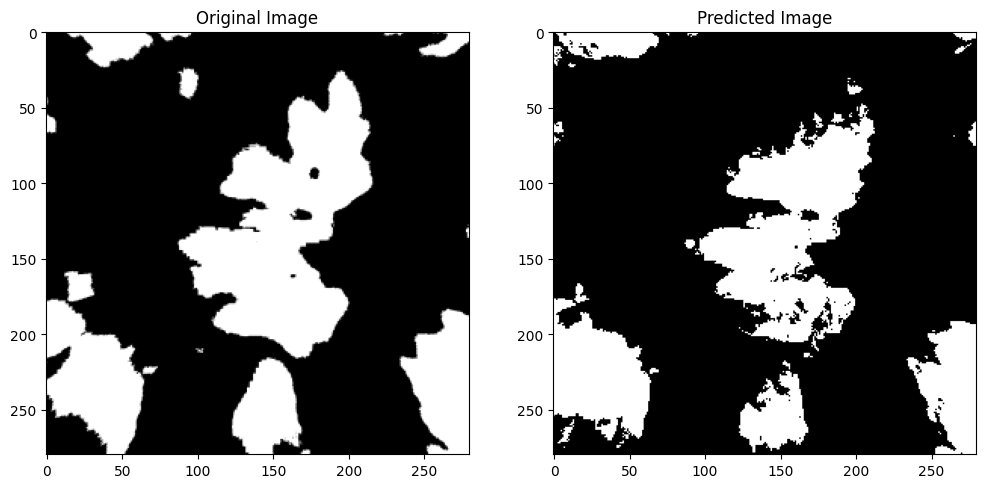

In [3]:
# Load your test images
i = 125
test_images = images[i:i+4]
test_images = test_images.reshape(1,4,280,280,1)
p = model.predict(test_images)
op = p[0] * 255
z = op.reshape(280, 280)
_, binary_z = cv2.threshold(z, 128, 255, cv2.THRESH_BINARY)

original_img = images[i+4]

# Plot the results
plt.figure(figsize=(12, 12))

# Display the original image
plt.subplot(121)
plt.title('Original Image')
plt.imshow(original_img, cmap='gray')

# Display the predicted image with binary colors
plt.subplot(122)
plt.title('Predicted Image')
plt.imshow(binary_z, cmap='gray')

plt.show()